In [1]:
import keras
import cooler
import bioframe as bf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import bbi
from matplotlib import gridspec

In [2]:
regions_path = '/home/users/luisfcd/data/regions/regions_10kb.tsv'
cool_path = '/home/users/luisfcd/data/Hi-C/GM12878/4DNFIXP4QG5B.mcool'
chip_path = '/home/users/luisfcd/data/CHIP/GM12878/'
regionsize = 4000000
resolution=10000

In [3]:
bigwig_dict = {}
for path in glob(chip_path+'**/*.bigWig', recursive=True):
    bigwig_dict[path.split('/')[-2]]=path

bigwig_dict

{'H3K27ac': '/home/users/luisfcd/data/CHIP/GM12878/H3K27ac/ENCFF469WVA.bigWig',
 'H3K27me3': '/home/users/luisfcd/data/CHIP/GM12878/H3K27me3/ENCFF919DOR.bigWig',
 'H3K9me3': '/home/users/luisfcd/data/CHIP/GM12878/H3K9me3/ENCFF683HCZ.bigWig'}

In [4]:
regions_array = np.squeeze(pd.read_csv(regions_path, header=None).values)
regions_df = bf.from_any(list(regions_array))

In [5]:
def get_all_regions(regions_df, regionsize, step=10000):
    mask = (regions_df.end - regions_df.start) > regionsize
    all_regions = []
    for i, row in regions_df[mask].iterrows():
        for k in range(0, (row.end - row.start)-regionsize+1, step):
            region = bf.to_ucsc_string((row.chrom, row.start+k, row.start+k+regionsize))
            all_regions.append(region)
    
    return bf.from_any(all_regions)

In [6]:
all_regions_df = get_all_regions(regions_df, regionsize)

In [36]:
all_regions_df

,chrom,start,end
0,chr1,2781250,6781250
1,chr1,2791250,6791250
2,chr1,2801250,6801250
3,chr1,2811250,6811250
4,chr1,2821250,6821250
...,...,...,...
182862,chr22,46710000,50710000
182863,chr22,46720000,50720000
182864,chr22,46730000,50730000
182865,chr22,46740000,50740000


In [8]:
def chip_loader(regions_df, path, resolution):
    with bbi.open(path) as f:
        for i, row in regions_df.iterrows():
            signal = f.fetch(row.chrom, row.start, row.end, bins=(row.end-row.start)//resolution)
            yield signal

In [29]:
def hic_loader(regions_df, path, resolution):
    c = cooler.Cooler(path+'::resolutions/'+str(resolution))
    for i, row in regions_df.iterrows():
        region = bf.to_ucsc_string((row.chrom, row.start, row.end))
        mat = c.matrix(balance=True).fetch(region)
        yield mat

In [34]:
target_regions_df = bf.select(all_regions_df, 'chr19').sample(frac=1, random_state=28) #select a chromosome and shuffle it
hic_generator = hic_loader(target_regions_df, cool_path, resolution=10000)
chip_generator_dict = {}
for key, value in bigwig_dict.items():
    chip_generator_dict[key] = chip_loader(target_regions_df, value, resolution=10000)

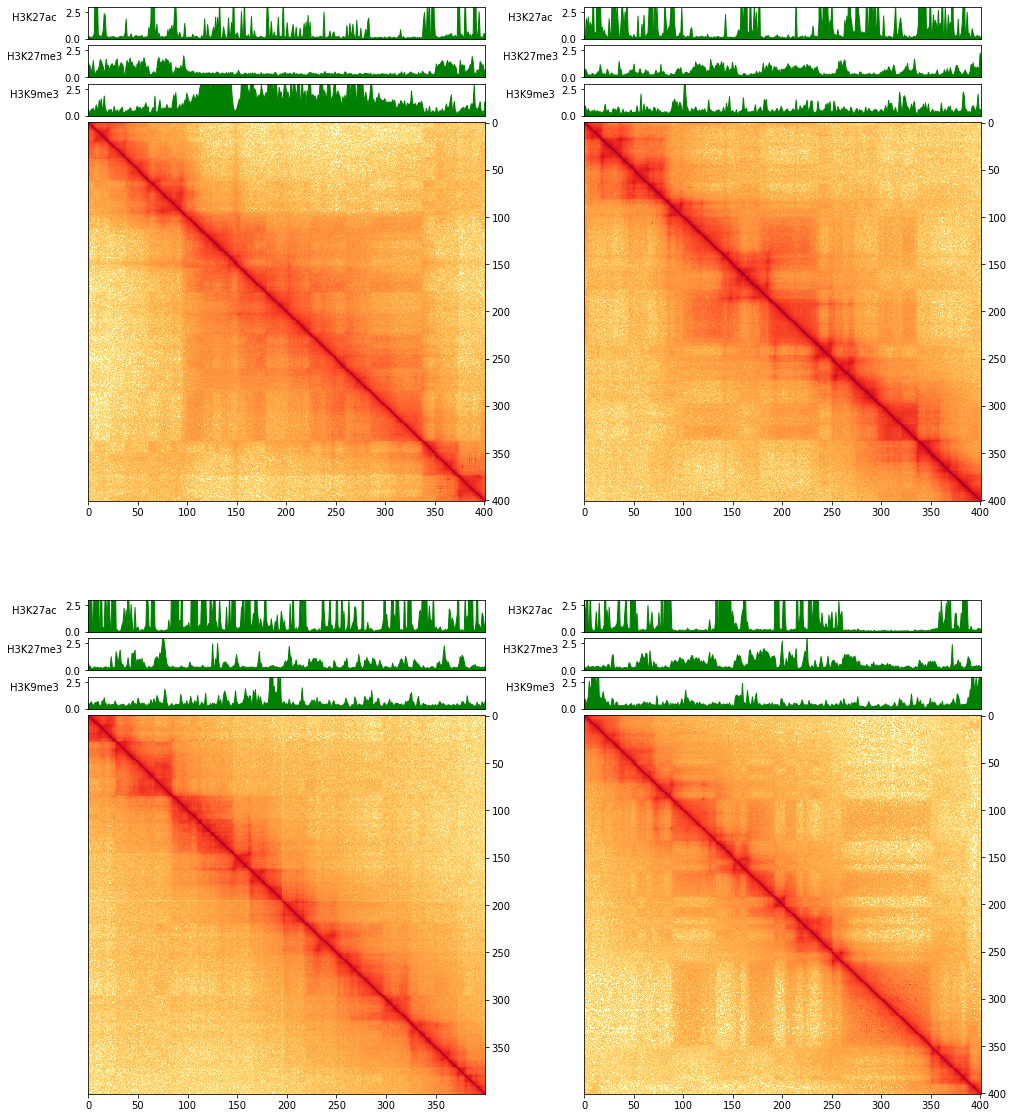

In [35]:
fig = plt.figure(figsize=(16,20))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.25)
for i in range(4):
    
    gss = gridspec.GridSpecFromSubplotSpec(13, 10, subplot_spec=gs[i])
    ax1= plt.subplot(gss[3:, :])
    mat = next(hic_generator)
    ax1.matshow(np.log10(mat + 5e-6),cmap = 'YlOrRd', aspect='auto', interpolation ='none')
    ax1.yaxis.set_ticks_position('right')
    ax1.xaxis.set_ticks_position('bottom')
    
    for k, (key, chip_generator) in enumerate(chip_generator_dict.items()):
        ax= plt.subplot(gss[k, :])
        
        y = next(chip_generator)
        x = np.arange(0, len(y))
        ax.fill_between(x, y,0, color='green')
        ax.margins(0)
        ax.get_xaxis().set_visible(False)
        ax.set_ylim([0, 3])
        ax.set_ylabel(key, rotation=0, labelpad=30)

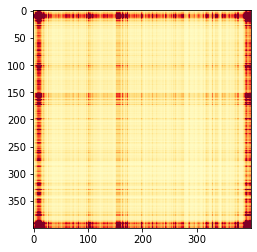

In [42]:
plt.imshow(np.outer(y,y), cmap='YlOrRd', vmax=np.max(y)*0.5)